<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/RiverWSE-Estimation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sorting by latitude (north-south cross-section).


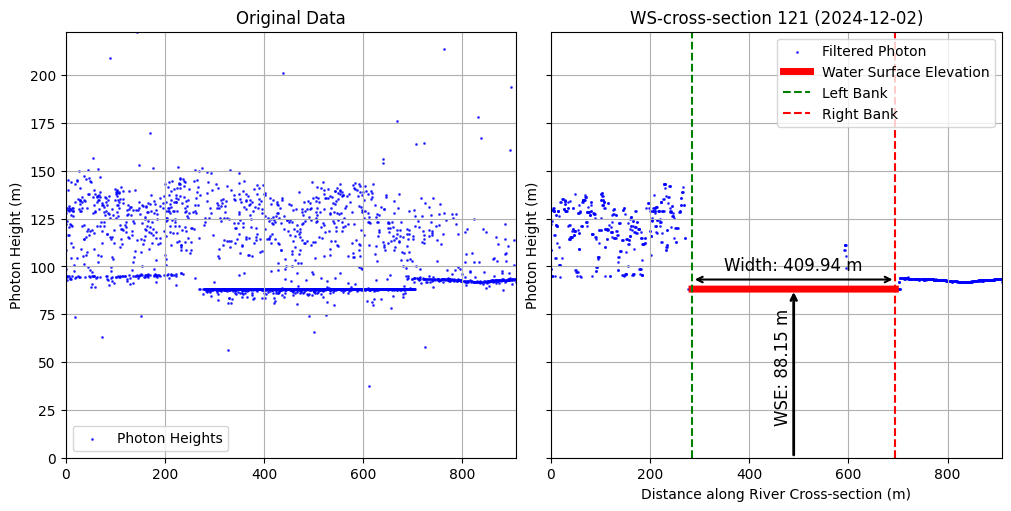

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.stats import gaussian_kde
import os
import re

# ------------------------------ Hampel Filter Function ------------------------------
def hampel_filter(data, window_size=20, threshold=7):
    filtered_data = data.copy()
    half_window = window_size // 2
    for i in range(half_window, len(data) - half_window):
        window = data[i - half_window:i + half_window + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        if mad == 0:
            continue
        if np.abs(data[i] - median) > threshold * mad:
            filtered_data[i] = median
    return filtered_data

# ------------------------------ Load Data ------------------------------
Initial_file_path = '/content/photon_2024-12-02_t1174_1747945002191.csv'
df_initial = pd.read_csv(Initial_file_path)

# Extract date from filename
filename = os.path.basename(Initial_file_path)
match = re.search(r'\d{4}-\d{2}-\d{2}', filename)
Date = match.group() if match else "Unknown"

# Extract relevant columns
latitude = df_initial.iloc[:, 1].values
longitude = df_initial.iloc[:, 2].values
photon_height = df_initial.iloc[:, 3].values

# Determine sorting order
lat_range = max(latitude) - min(latitude)
lon_range = max(longitude) - min(longitude)

if lat_range > lon_range:
    sorted_indices = np.argsort(latitude)
    print("Sorting by latitude (north-south cross-section).")
else:
    sorted_indices = np.argsort(longitude)
    print("Sorting by longitude (east-west cross-section).")

latitude = latitude[sorted_indices]
longitude = longitude[sorted_indices]
photon_height = photon_height[sorted_indices]

# ------------------------------ Filtering ------------------------------
stronger_filtered_photon_height = hampel_filter(photon_height, window_size=20, threshold=7)
final_filtered_photon_height = medfilt(stronger_filtered_photon_height, kernel_size=5)

# ------------------------------ Distance Calculation ------------------------------
lat_to_meters = 111320
lon_to_meters = 40075000 * np.cos(np.radians(np.mean(latitude))) / 360
cross_section_distances = np.cumsum(
    np.sqrt(np.diff(latitude)**2 * lat_to_meters**2 + np.diff(longitude)**2 * lon_to_meters**2)
)
cross_section_distances = np.insert(cross_section_distances, 0, 0)

# ------------------------------ Water Surface Filtering (Using KDE) ------------------------------
kde = gaussian_kde(final_filtered_photon_height, bw_method=0.2)
photon_height_range = np.linspace(min(final_filtered_photon_height), max(final_filtered_photon_height), 1000)
density_values = kde(photon_height_range)
peak_height = photon_height_range[np.argmax(density_values)]

water_surface_mask = (final_filtered_photon_height >= peak_height - 0.2) & (final_filtered_photon_height <= peak_height)
water_surface_heights = final_filtered_photon_height[water_surface_mask]
water_surface_distances = cross_section_distances[water_surface_mask]
average_water_surface_height = np.mean(water_surface_heights)

# ------------------------------ Remove Points Below Water Surface ------------------------------
above_water_surface_mask = final_filtered_photon_height >= average_water_surface_height
filtered_above_water_surface_distances = cross_section_distances[above_water_surface_mask]
filtered_above_water_surface_heights = final_filtered_photon_height[above_water_surface_mask]

# ------------------------------ River Width Estimation ------------------------------
left_bank = np.percentile(water_surface_distances, 1)
right_bank = np.percentile(water_surface_distances, 99)
river_width_percentile = right_bank - left_bank

# ------------------------------ Trimmed Surface Line ------------------------------
trimmed_mask = (cross_section_distances >= left_bank) & (cross_section_distances <= right_bank)
trimmed_distances = cross_section_distances[trimmed_mask]
trimmed_surface = np.full_like(trimmed_distances, average_water_surface_height)

# ------------------------------ Plotting ------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, constrained_layout=True)

x_min = min(np.min(cross_section_distances), np.min(filtered_above_water_surface_distances))
x_max = max(np.max(cross_section_distances), np.max(filtered_above_water_surface_distances))
y_min = min(np.min(photon_height), np.min(filtered_above_water_surface_heights))
y_max = max(np.max(photon_height), np.max(filtered_above_water_surface_heights))

# Original data plot
ax1.scatter(cross_section_distances, photon_height, color='blue', s=1, alpha=0.7, label="Photon Heights")
ax1.set_title('Original Data')
ax1.set_ylabel("Photon Height (m)")
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.legend(loc='best')
ax1.grid(True)

# Filtered data plot
ax2.scatter(filtered_above_water_surface_distances, filtered_above_water_surface_heights, color='blue', s=1, alpha=0.7, label="Filtered Photon")
ax2.plot(trimmed_distances, trimmed_surface, color='red', linestyle='-', linewidth=5, label="Water Surface Elevation")
ax2.set_title(f'WS-cross-section 121 ({Date})')
ax2.set_xlabel("Distance along River Cross-section (m)")
ax2.set_ylabel("Photon Height (m)")
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(0, y_max)
ax2.axvline(left_bank, color='green', linestyle='--', label='Left Bank')
ax2.axvline(right_bank, color='red', linestyle='--', label='Right Bank')

# Width annotation
ax2.annotate('', xy=(right_bank, average_water_surface_height + 5), xytext=(left_bank, average_water_surface_height + 5),
             arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
ax2.text((left_bank + right_bank) / 2, average_water_surface_height + 10,
         f'Width: {river_width_percentile:.2f} m',
         horizontalalignment='center', fontsize=12, color='black')

# WSE annotation
center_of_river = (left_bank + right_bank) / 2
ax2.annotate('', xy=(center_of_river, average_water_surface_height), xytext=(center_of_river, 0),
             arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax2.text(center_of_river - 40, average_water_surface_height - 10,
         f'WSE: {average_water_surface_height:.2f} m',
         verticalalignment='top', fontsize=12, color='black', rotation=90)

ax2.grid(True)
ax2.legend(loc='best')

plt.show()
